# Pricing an American Put option using Implicit Finite difference and Binomial Tree method 

We begin by Pricing an american option using the implicit finite difference method

In [128]:
# résolution de l'EDP de Black-Scholes par différences finies pour une option PUT américaine
# librairies
import numpy as np
import matplotlib.pyplot as plt
import time

In [129]:
# paramètres financiers
S0 = 147.12
r = 0.035
sigma = 0.2
T = 2.
K = 169.99

In [130]:
# paramètres numériques
N = 1000  # nb de points en prix
M = 100   # nb de points en temps
Smax = 1000  # prix maximum pour la résolution
dt = T / M
ds = Smax / N
print("Les pas de temps et prix sont:", dt, ds)

Les pas de temps et prix sont: 0.02 1.0


We use the code written in class by Prof Didier Auroux as baseline

In [131]:
# initialisation de la matrice V (valeurs de l'option)
V = np.zeros((M + 1, N + 1))

# tableau des prix S
S = ds * np.arange(N + 1)

# tableau des temps t
t = dt * np.arange(M + 1)

# prix finaux t=T (payoff pour un Put américain)
V[M, :] = np.maximum(K - S, 0)

# conditions aux bords en prix
V[:, 0] = K * np.exp(-r * (T - t))  # limite à S = 0
V[:, N] = 0.  # option sans valeur si S = Smax

\begin{equation}
    \begin{pmatrix}
        1+b_1 & c_1 & 0\cdots & 0\\
        a_2 & 1+b_2 & c_2\cdots & 0\\
        0 & a_3 & 1+b_3\cdots & 0\\
        \vdots & \vdots &\vdots &\vdots\\
        0 & 0 & 0 & a_{N-1}1+b_{N-1}
    \end{pmatrix}
    \begin{pmatrix}
        V_{i1}\\
        V_{i2}\\
        V_{i3}\\
        \vdots\\
        V_{i,N-1}
    \end{pmatrix}+
    \begin{pmatrix}
        a_1V_{i0}\\
        0\\
        0\\
        \vdots\\
        c_{N-1}V_{i,N}
    \end{pmatrix}=
    \begin{pmatrix}
        V_{i-11}\\
        V_{i-12}\\
        V_{i-13}\\
        \vdots\\
        V_{i-1,N-1}
    \end{pmatrix}
\end{equation}

In [132]:
# matrice du système linéaire (qui ne dépend pas du temps)
A = np.diag(-1 / dt - (sigma ** 2 / ds ** 2) * S[1:N] ** 2 - r * S[1:N] / ds - r) \
    + np.diag(0.5 * (sigma / ds) ** 2 * S[1:N - 1] ** 2 + r / ds * S[1:N - 1], 1) \
    + np.diag(0.5 * (sigma / ds) ** 2 * S[2:N] ** 2, -1)

We solve : $AV=B$

In [133]:
# on lance le chronomètre
start = time.time()

# boucle en temps 
for i in range(M - 1, -1, -1):
    # vecteur du second membre
    B = -1 / dt * V[i + 1, 1:N]
    
    # ajout des conditions aux bords
    B[0] += -0.5 * (sigma / ds) ** 2 * S[1] ** 2 * V[i, 0]
    B[N - 2] += (-0.5 * (sigma / ds) ** 2 * S[N - 1] ** 2 - r / ds * S[N - 1]) * V[i, N]
    
    # résolution du système Ax=b
    V[i, 1:N] = np.linalg.solve(A, B)
    
    # ajout de la condition d'exercice anticipé (American Put)
    V[i, :] = np.maximum(V[i, :], K - S)

end = time.time()
print(f"Temps d'exécution : {end - start:.2f} secondes")

Temps d'exécution : 3.19 secondes


We simulate our option price

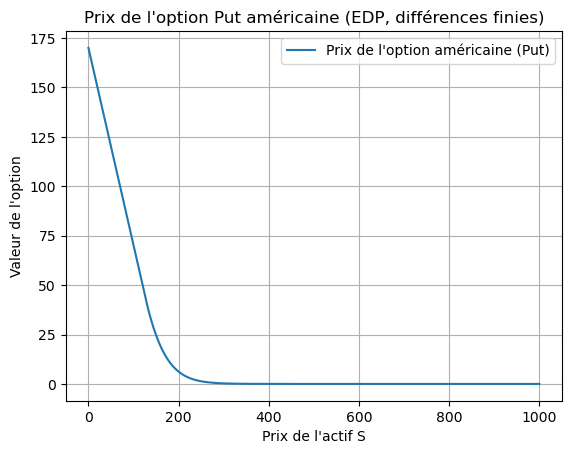

In [134]:
# Visualisation
plt.plot(S, V[0, :], label="Prix de l'option américaine (Put)")
plt.title("Prix de l'option Put américaine (EDP, différences finies)")
plt.xlabel("Prix de l'actif S")
plt.ylabel("Valeur de l'option")
plt.grid()
plt.legend()
plt.savefig('American_put')
plt.show()

In order to simulate for different values of $\sigma$ the volatility, we rewrite the above code as a function

In [135]:
# valeurs de sigma à tester
sigma_values = [0.1, 0.2, 0.3, 0.5]
resultat = []

# Boucle pour différentes valeurs de sigma
for sigma in sigma_values:
    # initialisation de la matrice V (valeurs de l'option)
    V = np.zeros((M + 1, N + 1))

    # prix finaux t=T (payoff pour un Put américain)
    V[M, :] = np.maximum(K - S, 0)

    # conditions aux bords en prix
    V[:, 0] = K * np.exp(-r * (T - np.arange(M + 1) * dt))  # limite à S = 0
    V[:, N] = 0.  # option sans valeur si S = Smax

    # matrice du système linéaire (qui ne dépend pas du temps)
    A = np.diag(-1 / dt - (sigma ** 2 / ds ** 2) * S[1:N] ** 2 - r * S[1:N] / ds - r) \
        + np.diag(0.5 * (sigma / ds) ** 2 * S[1:N - 1] ** 2 + r / ds * S[1:N - 1], 1) \
        + np.diag(0.5 * (sigma / ds) ** 2 * S[2:N] ** 2, -1)

    # boucle en temps 
    for i in range(M - 1, -1, -1):
        # vecteur du second membre
        B = -1 / dt * V[i + 1, 1:N]
        
        # ajout des conditions aux bords
        B[0] += -0.5 * (sigma / ds) ** 2 * S[1] ** 2 * V[i, 0]
        B[N - 2] += (-0.5 * (sigma / ds) ** 2 * S[N - 1] ** 2 - r / ds * S[N - 1]) * V[i, N]
        
        # résolution du système Ax=b
        V[i, 1:N] = np.linalg.solve(A, B)
        
        # ajout de la condition d'exercice anticipé (American Put)
        V[i, :] = np.maximum(V[i, :], K - S)

    # Sauvegarder les résultats pour cette valeur de sigma
    resultat.append(V[0, :])

We plot for different values of sigma to observe the effect of the volatility

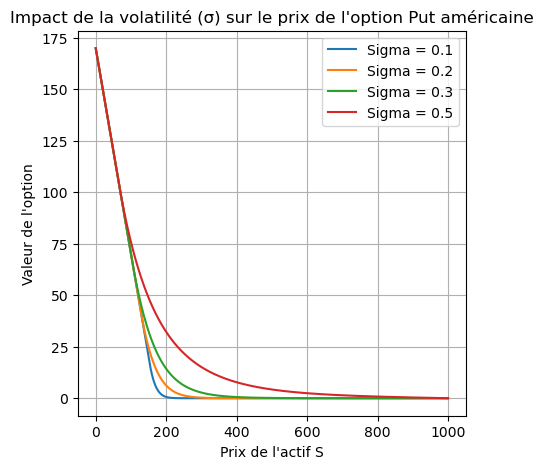

In [136]:
# Visualisation des résultats pour différentes valeurs de sigma
plt.figure(figsize=(5, 5))
for i, sigma in enumerate(sigma_values):
    plt.plot(S, resultat[i], label=f"Sigma = {sigma}")

plt.title("Impact de la volatilité (σ) sur le prix de l'option Put américaine")
plt.xlabel("Prix de l'actif S")
plt.ylabel("Valeur de l'option")
plt.legend()
plt.grid()
plt.savefig('volatilite_put')
plt.show()

In [137]:
# paramètres numériques pour un prémier test
S0 = 147.12 #prix initiale de l'actif
K = 169.99  #prix d'écheance
T = 2    # Maturité 
r = 0.035 #rendement
N=3      # pas
u = 1.2  #'up-factor'
d = 1/u  #assurer un arbre recombinant
opttype = 'p' #Type d'Option

In [138]:
def american_bin_tree(K,T,S0,r,N,u,d,opttype='p'):
    #précalculer les valeurs
    dt = T/N
    q = (np.exp(r*dt)-d)/(u-d)
    disc = np.exp(-r*dt)
    #initialisation du prix de l'actif a maturité 
    S = S0*d**(np.arange(N,-1,-1))*u**(np.arange(0,N+1,1))
    
    #option payoff
    
    if opttype == 'p':
        C = np.maximum(0, K-S)
    else:
        C = np.maximum(0, S-K)
        
    #récursion arrière à travers l'arbre
    for i in np.arange(N-1,-1,-1):
        S=S0*d**(np.arange(i,-1,-1))*u**(np.arange(0,i+1,1))
        C[:i+1] = disc*(q*C[1:i+2]+(1-q)*C[0:i+1])
        C = C[:-1]
        if opttype == 'p':
            C = np.maximum(C, K-S)
        else:
            C = np.maximum(C, S-K)
    return C[0]
american_bin_tree(K,T,S0,r,N,u,d,opttype='p')

27.72110349467512

In [149]:
# Résolution par différences finies pour une option put américaine
def finite_difference_american_put(S0, K, T, r, sigma, Smax, M, N):
    dt = T / M
    ds = Smax / N

    # Matrice pour stocker les valeurs de l'option
    V = np.zeros((M + 1, N + 1))
    S = ds * np.arange(N + 1)

    # Condition terminale (payoff)
    V[M, :] = np.maximum(K - S, 0)

    # Conditions aux bords
    V[:, 0] = K * np.exp(-r * (T - np.linspace(0, T, M + 1)))
    V[:, N] = 0

    # Matrice du système linéaire
    A = np.diag(-1 / dt - (sigma ** 2 / ds ** 2) * S[1:N] ** 2 - r * S[1:N] / ds - r) \
        + np.diag(0.5 * (sigma / ds) ** 2 * S[1:N - 1] ** 2 + r / ds * S[1:N - 1], 1) \
        + np.diag(0.5 * (sigma / ds) ** 2 * S[2:N] ** 2, -1)

    # Backward recursion
    for i in range(M - 1, -1, -1):
        B = -1 / dt * V[i + 1, 1:N]
        B[0] += -0.5 * (sigma / ds) ** 2 * S[1] ** 2 * V[i, 0]
        B[N - 2] += (-0.5 * (sigma / ds) ** 2 * S[N - 1] ** 2 - r / ds * S[N - 1]) * V[i, N]
        V[i, 1:N] = np.linalg.solve(A, B)
        V[i, :] = np.maximum(V[i, :], K - S)  # Condition d'exercice anticipé

    return V[0, int(S0 / ds)]  # Retourne le prix initial

# Paramètres financiers
S0 = 100
K = 100
T = 2
r = 0.035
sigma = 0.2
opttype = 'p'

# Paramètres numériques pour comparaison
N = 500  # Nombre de pas dans l'arbre binomial ou divisions en prix
M = N    # Nombre de pas en temps pour différences finies (même grille)
Smax_fd = 200  # Prix maximal pour différences finies

# Résolution par arbre binomial
price_binomial = american_fast_tree(K, T, S0, r, N, np.exp(-sigma * np.sqrt(T / N)), np.exp(sigma * np.sqrt(T / N)), opttype)

# Résolution par différences finies
price_fd = finite_difference_american_put(S0, K, T, r, sigma, Smax_fd, M, N)

# Affichage des résultats
print(f"Prix avec l'arbre binomial : {price_binomial:.6f}")
print(f"Prix avec différences finies : {price_fd:.6f}")

Prix avec l'arbre binomial : 8.569963
Prix avec différences finies : 8.583025


We test for multiple steps

In [150]:
#pour different pas
for N in [3,50,100,1000,2000]:
    print(american_bin_tree(K,T,S0,r,N,u,d,opttype='p'))

10.481533038715702
44.04724195691744
59.53921951558289
97.03124238718098
98.49627829501617


We run for multiple values of N to compare both methods and we calculate their root mean square values

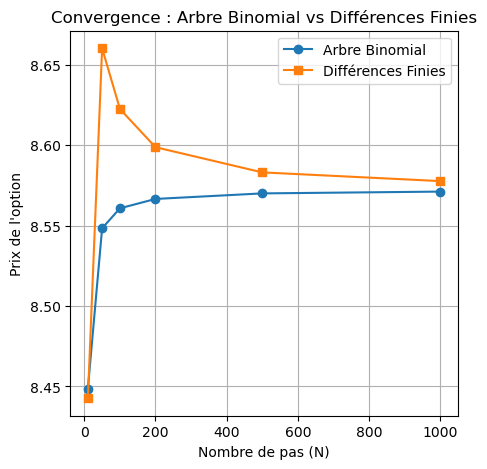

Prix avec la méthode binomiale : [8.448747   8.54830221 8.56070322 8.56652341 8.56996337 8.57108047]
Prix avec la méthode des différences finies : [8.44270852 8.6601627  8.62240183 8.59867377 8.5830245  8.5776099 ]
Erreur quadratique moyenne (RMSE) entre les deux méthodes : 0.054165


In [151]:
import numpy as np
import matplotlib.pyplot as plt

# Analyse de convergence
N_values = [10, 50, 100, 200, 500, 1000]
prices_binomial = []
prices_fd = []

for N in N_values:
    M = N
    # Calcul des prix avec les deux méthodes
    price_binomial = american_fast_tree(K, T, S0, r, N, np.exp(-sigma * np.sqrt(T / N)), np.exp(sigma * np.sqrt(T / N)), opttype)
    price_fd = finite_difference_american_put(S0, K, T, r, sigma, Smax_fd, M, N)
    
    prices_binomial.append(price_binomial)
    prices_fd.append(price_fd)

# Calcul de la RMSE
prices_binomial = np.array(prices_binomial)
prices_fd = np.array(prices_fd)
rmse = np.sqrt(np.mean((prices_binomial - prices_fd) ** 2))

# Affichage des résultats
plt.figure(figsize=(5, 5))
plt.plot(N_values, prices_binomial, label='Arbre Binomial', marker='o')
plt.plot(N_values, prices_fd, label='Différences Finies', marker='s')
plt.xlabel("Nombre de pas (N)")
plt.ylabel("Prix de l'option")
plt.title("Convergence : Arbre Binomial vs Différences Finies")
plt.legend()
plt.grid()
plt.savefig('compare_put')
plt.show()

print("Prix avec la méthode binomiale :", prices_binomial)
print("Prix avec la méthode des différences finies :", prices_fd)
print(f"Erreur quadratique moyenne (RMSE) entre les deux méthodes : {rmse:.6f}")